In [2]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt

In [19]:
file_path = 'itokawa_f0049152.obj'
#file_path = 'bennu.obj'

In [ ]:
def load_and_process_mesh(file_path: str):
    """
    加载.obj mesh, 导出 centroids & normals.
    """
   
    mesh = trimesh.load(file_path, force='mesh')
    # 缩小10倍(规模与2016HO3相似)
    mesh.apply_scale(0.1)
    if not mesh.is_watertight or mesh.faces.shape[1] != 3:
        mesh = mesh.subdivide()

    vertices = mesh.vertices  
    faces = mesh.faces        

    triangles = vertices[faces]  
    patch_positions = np.mean(triangles, axis=1) 

    v1 = triangles[:, 1] - triangles[:, 0]
    v2 = triangles[:, 2] - triangles[:, 0]
    normals = np.cross(v1, v2)
    norms = np.linalg.norm(normals, axis=1, keepdims=True)
    patch_normals = normals / np.maximum(norms, 1e-8)

    return mesh, patch_positions, patch_normals

In [21]:
mesh, centers, normals = load_and_process_mesh(file_path)

In [ ]:
print("Example patch position:", centers[0])
print("Mesh bounding box extent:", mesh.bounding_box.extents)


Example patch position: [-14.30286153   7.74057058   7.21855214]
Mesh bounding box extent: [53.4949707  29.13378754 23.23602829]


In [ ]:
# def plot_patches(centers, normals):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.quiver(centers[:, 0], centers[:, 1], centers[:, 2],
#               normals[:, 0], normals[:, 1], normals[:, 2],
#               length=0.1, normalize=True)
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     plt.show()

In [ ]:
def visible_by_square_fov_with_angle_limit(patch_positions,
                                           patch_normals,
                                           camera_pos,
                                           target=np.zeros(3),
                                           fov_x_deg=2.0,
                                           fov_y_deg=2.0,
                                           max_angle_deg=45.0):
    """
    返回 Boolean mask，指示哪些 patch 在方锥视锥 (底面正方形) 内，
    且面朝向相机，且法向量与视线方向夹角不超过指定角度。
    """
    # 1. 构造相机坐标系
    z_cam = (target - camera_pos)
    z_cam = z_cam / np.linalg.norm(z_cam)
    world_up = np.array([0, 0, 1], dtype=float)
    x_cam = np.cross(z_cam, world_up)
    x_cam /= np.linalg.norm(x_cam)
    y_cam = np.cross(x_cam, z_cam)

    view_vectors = patch_positions - camera_pos[None, :]
    z_coords = view_vectors.dot(z_cam)

    in_front = z_coords > 0

    view_distances = np.linalg.norm(view_vectors, axis=1, keepdims=True)
    view_directions = view_vectors / view_distances

    dot_products = np.einsum('ij,ij->i', patch_normals, view_directions)
    
    facing_camera = dot_products < 0
    
    # 角度限制检查：夹角不超过 max_angle_deg
    # 由于已经确保 dot < 0，检查 |dot| >= cos(max_angle_deg)
    # 即 dot <= -cos(max_angle_deg)
    cos_max_angle = np.cos(np.deg2rad(max_angle_deg))
    good_viewing_angle = dot_products <= -cos_max_angle

    x_coords = view_vectors.dot(x_cam)
    y_coords = view_vectors.dot(y_cam)
    
    tan_x = np.abs(x_coords / z_coords)
    tan_y = np.abs(y_coords / z_coords)
    
    # 视场角阈值
    tan_fov_x_half = np.tan(np.deg2rad(fov_x_deg / 2))
    tan_fov_y_half = np.tan(np.deg2rad(fov_y_deg / 2))
    
    within_fov_x = tan_x <= tan_fov_x_half
    within_fov_y = tan_y <= tan_fov_y_half

    visible_mask = (in_front & 
                   facing_camera & 
                   good_viewing_angle & 
                   within_fov_x & 
                   within_fov_y)
    
    return visible_mask

In [ ]:
def filter_occluded(mesh: trimesh.Trimesh,
                    patch_positions: np.ndarray,
                    camera_pos: np.ndarray,
                    candidate_mask: np.ndarray):
    """
    在候选可见面片中，筛除被遮挡的面片。从相机向每个候选面片发射射线，如果射线在到达目标面片之前
    与网格的其他部分相交，则该面片被遮挡。
    """
    visible_mask = candidate_mask.copy()
    
    if not np.any(candidate_mask):
        return visible_mask
    
    candidate_positions = patch_positions[candidate_mask]
    n_candidates = len(candidate_positions)

    ray_origins = np.repeat(camera_pos[None, :], n_candidates, axis=0)
    ray_directions = candidate_positions - camera_pos[None, :]
    ray_distances = np.linalg.norm(ray_directions, axis=1)
    ray_directions = ray_directions / ray_distances[:, None]
    
    # 获取所有射线与网格的相交信息
    locations, index_ray, index_tri = mesh.ray.intersects_location(
        ray_origins=ray_origins,
        ray_directions=ray_directions
    )
    
    if len(locations) == 0:
        return visible_mask
    
    intersect_distances = np.linalg.norm(locations - camera_pos[None, :], axis=1)
    
    is_occluded = np.zeros(n_candidates, dtype=bool)
    
    for i in range(n_candidates):
        ray_mask = index_ray == i
        if not np.any(ray_mask):
            continue

        ray_intersect_distances = intersect_distances[ray_mask]
        target_distance = ray_distances[i]
        
        # 如果存在比目标面片更近的相交点，则目标面片被遮挡
        # 使用容差来避免数值误差
        tolerance = target_distance * 1e-6 + 1e-8  # 相对容差 + 绝对容差
        closer_intersections = ray_intersect_distances < (target_distance - tolerance)
        
        if np.any(closer_intersections):
            is_occluded[i] = True
    
    visible_mask[candidate_mask] = ~is_occluded
    return visible_mask

In [86]:
# 第一步：先用 fov + 法向量进行初步筛选
theta =  -np.pi /4 * 0   # 0° 到 360°

camera_pos = np.array([600 * np.cos(theta), 600 * np.sin(theta), 0.])
fov = 2.0   
pre_mask = visible_by_square_fov_with_angle_limit(centers,
                                normals,
                                camera_pos,
                                target=np.zeros(3),
                                fov_x_deg=fov,
                                fov_y_deg=fov,
                                max_angle_deg=60.0)

# 第二步：做遮挡判定
final_mask = filter_occluded(mesh, centers, camera_pos, pre_mask)


In [87]:
print(f"方锥 FoV 内面片数：{pre_mask.sum()}")
print(f"遮挡后可见面片数：{final_mask.sum()}")

方锥 FoV 内面片数：3109
遮挡后可见面片数：2947


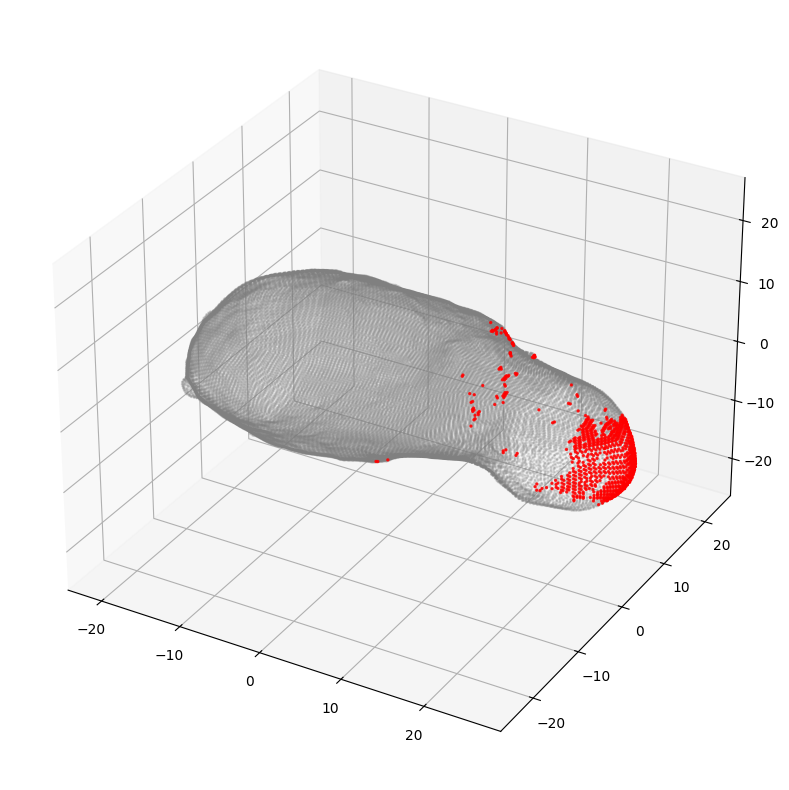

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax  = fig.add_subplot(111, projection='3d')

# 绘制点云
ax.scatter(centers[~final_mask,0],
           centers[~final_mask,1],
           centers[~final_mask,2],
           s=1, alpha=0.2, color='gray')
ax.scatter(centers[ final_mask,0],
           centers[ final_mask,1],
           centers[ final_mask,2],
           s=2, alpha=0.8, color='red')
# ax.scatter([camera_pos[0]], [camera_pos[1]], [camera_pos[2]],
#            color='blue', s=50, label='Camera')
# ax.plot([camera_pos[0], 0], [camera_pos[1], 0], [camera_pos[2], 0],
#         color='blue', linestyle='--')

# 计算每个轴的范围
x_min, x_max = centers[:,0].min(), centers[:,0].max()
y_min, y_max = centers[:,1].min(), centers[:,1].max()
z_min, z_max = centers[:,2].min(), centers[:,2].max()

# 设置轴范围为真实比例（非等距压缩）
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

def set_axes_equal(ax):
    '''使三轴比例一致，但保留真实物理范围'''
    x_range = x_max - x_min
    y_range = y_max - y_min
    z_range = z_max - z_min
    max_range = max(x_range, y_range, z_range)

    x_middle = (x_max + x_min) / 2
    y_middle = (y_max + y_min) / 2
    z_middle = (z_max + z_min) / 2

    ax.set_xlim(x_middle - max_range/2, x_middle + max_range/2)
    ax.set_ylim(y_middle - max_range/2, y_middle + max_range/2)
    ax.set_zlim(z_middle - max_range/2, z_middle + max_range/2)


set_axes_equal(ax)

plt.tight_layout()
plt.show()


# ax.scatter([camera_pos[0]], [camera_pos[1]], [camera_pos[2]],
#            color='blue', s=50, label='Camera')
# ax.plot([camera_pos[0], 0], [camera_pos[1], 0], [camera_pos[2], 0],
#         color='blue', linestyle='--')

In [ ]:
def filter_sun_occluded(mesh: trimesh.Trimesh,
                        patch_positions: np.ndarray,
                        candidate_mask: np.ndarray,
                        sun_direction: np.ndarray):
    """
    判断哪些候选面片被太阳照亮。若从太阳方向来的光线在到达该面片之前被其他三角面片遮挡，则该面片不被照亮。
    """
    illuminated_mask = candidate_mask.copy()
    if not np.any(candidate_mask):
        return illuminated_mask

    sun_direction = sun_direction / np.linalg.norm(sun_direction)
    candidate_positions = patch_positions[candidate_mask]
    n_candidates = len(candidate_positions)

    ray_origins = candidate_positions - sun_direction * 1e-2  # 避免自交
    ray_directions = np.tile(sun_direction, (n_candidates, 1))  # 所有方向相同

    locations, index_ray, index_tri = mesh.ray.intersects_location(
        ray_origins=ray_origins,
        ray_directions=ray_directions
    )

    is_shadowed = np.zeros(n_candidates, dtype=bool)

    for i in range(n_candidates):
        ray_mask = index_ray == i
        if not np.any(ray_mask):
            continue

        ray_locs = locations[ray_mask]
        patch_pos = candidate_positions[i]
        dists = np.linalg.norm(ray_locs - ray_origins[i], axis=1)

        # 判断是否第一个交点就是目标 patch。如果不是，说明有遮挡
        # 如果有任何交点比目标 patch 还近，则为被遮挡
        actual_dist = np.linalg.norm(patch_pos - ray_origins[i])
        tolerance = actual_dist * 1e-6 + 1e-8
        if np.any(dists < (actual_dist - tolerance)):
            is_shadowed[i] = True

    illuminated_mask[candidate_mask] = ~is_shadowed
    return illuminated_mask

In [ ]:
def check_reflection_condition(patch_positions, patch_normals, camera_pos, 
                             sun_direction, max_reflection_angle_deg):
    """
    检查反射光线是否朝向相机，满足镜面反射条件。
    """
    view_directions = camera_pos[None, :] - patch_positions
    view_directions = view_directions / np.linalg.norm(view_directions, axis=1, keepdims=True)
    # R = 2 * (N · L) * N - L
    dot_nl = np.dot(patch_normals, sun_direction)
    reflection_directions = (2 * dot_nl[:, None] * patch_normals - 
                           sun_direction[None, :])

    reflection_directions = (reflection_directions / 
                           np.linalg.norm(reflection_directions, axis=1, keepdims=True))

    dot_rv = np.einsum('ij,ij->i', reflection_directions, view_directions)
    
    # 角度条件 cos(angle) >= cos(max_angle)
    cos_max_angle = np.cos(np.deg2rad(max_reflection_angle_deg))
    good_reflection = dot_rv >= cos_max_angle
    return good_reflection

In [ ]:
def check_light_illumination(patch_normals, sun_direction, max_sun_angle_deg):
    """
    检查面片是否被太阳光充分照射。
    """
    # 计算太阳光方向与面片法向量的点积
    # 如果点积为正，说明光线从正面照射面片
    dot_products = np.dot(patch_normals, sun_direction)
    # 面片必须朝向太阳光（dot > 0）
    facing_sun = dot_products > 0
    # 角度不能太大（cos(angle) >= cos(max_angle)）
    cos_max_angle = np.cos(np.deg2rad(max_sun_angle_deg))
    good_sun_angle = dot_products >= cos_max_angle
    
    return facing_sun & good_sun_angle

In [104]:
def visible_with_lighting_conditions(patch_positions,
                                   patch_normals,
                                   camera_pos,
                                   sun_direction,
                                   mesh=mesh,
                                   target=np.zeros(3),
                                   fov_x_deg=2.0,
                                   fov_y_deg=2.0,
                                   max_viewing_angle_deg=60.0,
                                   max_sun_angle_deg=60.0,
                                   max_reflection_angle_deg=30.0):
    """
    综合考虑几何可见性和光照条件的面片可见性检测。
    """
    geometric_visible = visible_by_square_fov_with_angle_limit(
        patch_positions, patch_normals, camera_pos, target,
        fov_x_deg, fov_y_deg, max_viewing_angle_deg
    )

    candidate_indices = np.where(geometric_visible)[0]
    candidate_positions = patch_positions[candidate_indices]
    candidate_normals = patch_normals[candidate_indices]
    
    # 检查光照角度
    light_illuminated = check_light_illumination(
        candidate_normals, sun_direction, max_sun_angle_deg
    )
    
    # 检查反射光线
    reflection_good = check_reflection_condition(
        candidate_positions, candidate_normals, camera_pos, 
        sun_direction, max_reflection_angle_deg
    )
    
    # 检查光照遮挡条件
    if mesh is not None:
        light_unoccluded = filter_sun_occluded(
            mesh, candidate_positions, reflection_good, sun_direction
        )
    else:
        light_unoccluded = np.ones(len(candidate_indices), dtype=bool)
    
    lighting_conditions = light_illuminated & reflection_good & light_unoccluded

    final_visible_mask = np.zeros_like(geometric_visible)
    final_visible_mask[candidate_indices] = lighting_conditions
    
    visibility_breakdown = {
        "geometric_visible": np.sum(geometric_visible),
        "light_illuminated": np.sum(light_illuminated),
        "reflection_good": np.sum(reflection_good),
        "light_unoccluded": np.sum(light_unoccluded),
        "final_visible": np.sum(final_visible_mask)
    }
    
    return final_visible_mask, visibility_breakdown

In [ ]:
def analyze_lighting_visibility(patch_positions, patch_normals, camera_pos, 
                              sun_direction, mesh=mesh, **kwargs,
                              ):
    """
    分析光照可见性的详细统计信息
    """
    final_mask, breakdown = visible_with_lighting_conditions(
        patch_positions, patch_normals, camera_pos, sun_direction, 
        mesh, **kwargs, max_viewing_angle_deg=60.0,max_sun_angle_deg=60.0,max_reflection_angle_deg=150.0
    )
    
    total_patches = len(patch_positions)
    
    print("=== 光照可见性分析 ===")
    print(f"总面片数: {total_patches}")
    print(f"几何可见: {breakdown['geometric_visible']} "
          f"({breakdown['geometric_visible']/total_patches*100:.1f}%)")
    
    if breakdown['geometric_visible'] > 0:
        geo_base = breakdown['geometric_visible']
        print(f"光照充足: {breakdown['light_illuminated']} "
              f"({breakdown['light_illuminated']/geo_base*100:.1f}% of geometric)")
        print(f"反射条件满足: {breakdown['reflection_good']} "
              f"({breakdown['reflection_good']/geo_base*100:.1f}% of geometric)")
        print(f"光照无遮挡: {breakdown['light_unoccluded']} "
              f"({breakdown['light_unoccluded']/geo_base*100:.1f}% of geometric)")
    
    print(f"最终可见: {breakdown['final_visible']} "
          f"({breakdown['final_visible']/total_patches*100:.1f}% of total)")
    
    # 分析太阳光角度分布
    sun_angles = np.rad2deg(np.arccos(np.clip(
        np.dot(patch_normals, sun_direction), 0, 1
    )))
    facing_sun = np.dot(patch_normals, sun_direction) > 0
    
    if np.any(facing_sun):
        print(f"\n太阳光照角度分析:")
        print(f"朝向太阳的面片: {np.sum(facing_sun)} "
              f"({np.sum(facing_sun)/total_patches*100:.1f}%)")
        sun_angles_facing = sun_angles[facing_sun]
        print(f"平均光照角度: {np.mean(sun_angles_facing):.1f}°")
        print(f"光照角度范围: {np.min(sun_angles_facing):.1f}° - "
              f"{np.max(sun_angles_facing):.1f}°")
    return final_mask, breakdown

In [ ]:
sun_direction = np.array([-np.cos(theta), -np.sin(theta), 0.])  # 向下60度角
sun_direction = sun_direction / np.linalg.norm(sun_direction)

# 进行光照可见性检测
visible_mask, stats = visible_with_lighting_conditions(
    patch_positions=centers,
    patch_normals=normals,
    camera_pos=camera_pos,
    sun_direction=sun_direction,
    mesh=mesh,
    max_sun_angle_deg=90.0,        # 太阳光最大入射角
    max_reflection_angle_deg=150.0,  # 反射光最大偏差角
    max_viewing_angle_deg=60.0      # 观测最大角度
)

# 分析结果
analyze_lighting_visibility(
    centers, normals, camera_pos, sun_direction, mesh
)

=== 光照可见性分析 ===
总面片数: 49152
几何可见: 3109 (6.3%)
光照充足: 0 (0.0% of geometric)
反射条件满足: 3062 (98.5% of geometric)
光照无遮挡: 3062 (98.5% of geometric)
最终可见: 0 (0.0% of total)

太阳光照角度分析:
朝向太阳的面片: 22272 (45.3%)
平均光照角度: 69.8°
光照角度范围: 0.7° - 90.0°


(TrackedArray([False, False, False, ..., False, False, False]),
 {'geometric_visible': 3109,
  'light_illuminated': 0,
  'reflection_good': 3062,
  'light_unoccluded': 3062,
  'final_visible': 0})